In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.shape

(768, 9)

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Display the outcome distribution
outcome = data['Outcome'].value_counts()
# checking the percentage
outcome_per = 100 * data['Outcome'].value_counts() / len(data)
print(outcome)
print(outcome_per)

Outcome
0    500
1    268
Name: count, dtype: int64
Outcome
0    65.104167
1    34.895833
Name: count, dtype: float64


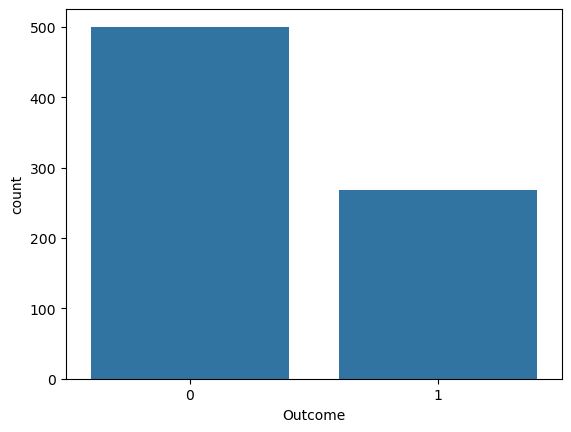

In [7]:
# Visualising the distribution of the outcome 
sns.countplot(x='Outcome', data=data)
plt.show()

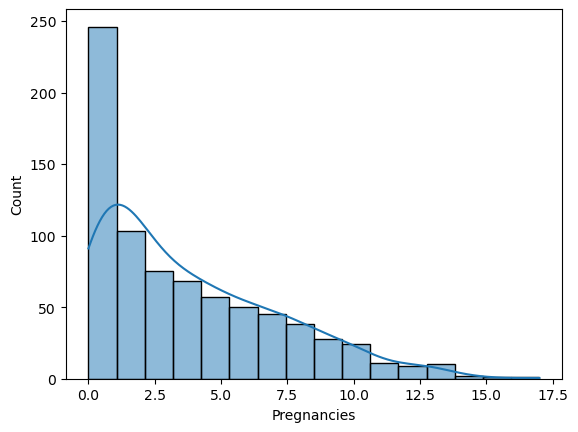

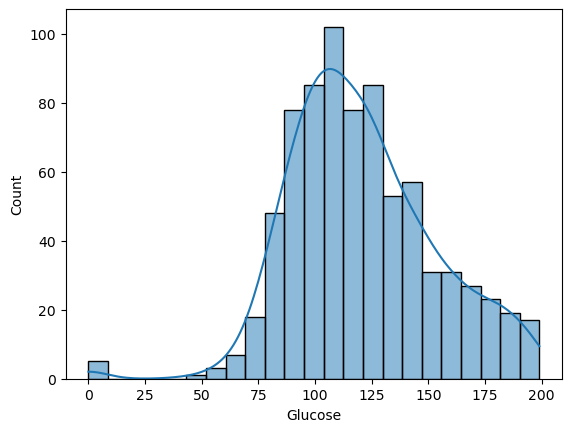

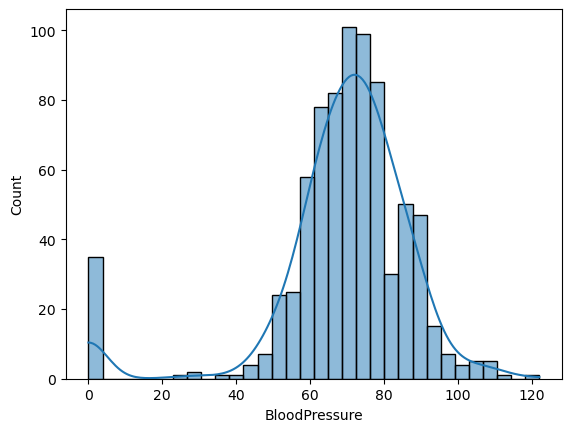

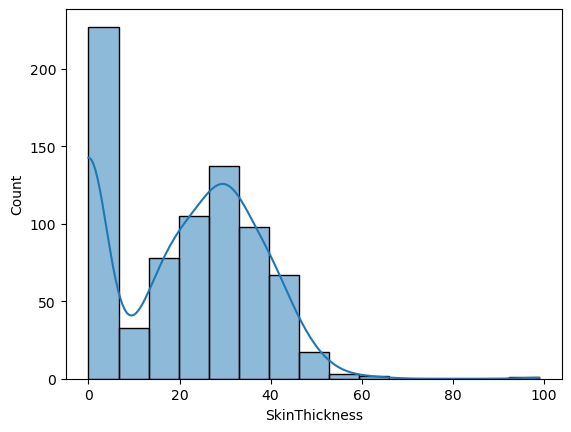

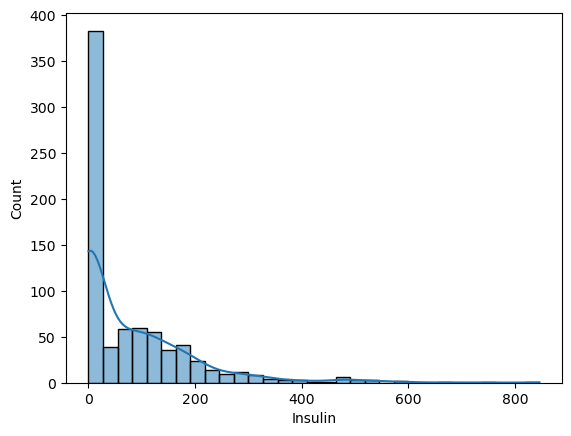

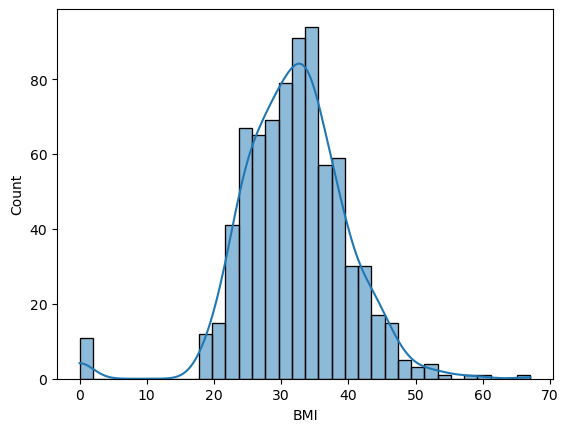

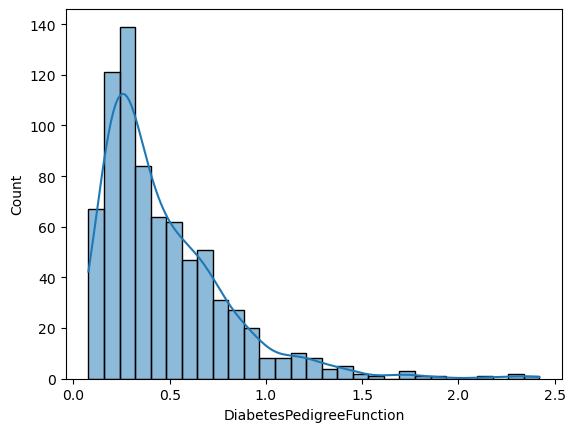

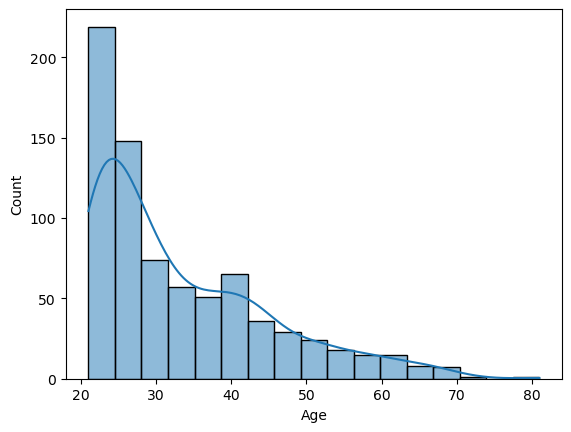

In [8]:
# Define a function to check all numerical columns
def plot_numerical_col(dataframe, numerical_col):
    # dataframe[numerical_col].hist(bins=20)
    sns.histplot(dataframe[numerical_col], kde=True)
    plt.xlabel(numerical_col)
    plt.show()

# Excluding the target variable
cols = [col for col in data.columns if "Outcome" not in col]


for col in cols:
    plot_numerical_col(data, col)

In [9]:
# Creating a function to check each feature individually
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}), end='\n\n\n')

# checkinh each numerical column individually
for col in cols:
    target_summary_with_num(data, 'Outcome', col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [10]:
#outlier detection and cleaning functions
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [11]:
# Checking for outliers inthe data
for col in cols:
    print(col, check_outlier(data, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [12]:
# Displaying the outlier values in the "Insulin" variable
replace_with_thresholds(data, "Insulin")

In [13]:
# Fitting and transforming all features with standard scale
# Create a copy of the original dataframe
scaled_data = data.copy()

for col in cols:
    scaler = StandardScaler()
    scaled_data[col] = scaler.fit_transform(data[[col]])

# scaled data conatins the scaled values
scaled_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.697537,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.697537,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.697537,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.125808,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.773973,1.409746,5.484909,-0.020496,1


In [14]:
# Model
# Defining the variable
y = scaled_data['Outcome']
X = scaled_data.drop(['Outcome'], axis=1)

In [15]:
# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)


(614, 8)
(154, 8)


In [16]:
# Create an instance of the LogisticRegression class
model = LogisticRegression()
# Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Make predictions on the testing data
y_pred = model.predict(X_test)

In [18]:
# Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



### Metric Evaluation

The classification_report provides a detailed breakdown of the model's performance. Here's an interpretation of the key metrics:

Precision: The proportion of true positive predictions among all positive predictions. For class 0, precision is 0.81, and for class 1, precision is 0.65. This means that when the model predicts class 0, it is correct 81% of the time, and for class 1, it is correct 65% of the time.

Recall (Sensitivity): The proportion of true positive predictions among all actual positives. For class 0, recall is 0.80, and for class 1, recall is 0.67. This means that the model correctly identifies 80% of all actual class 0 instances and 67% of all actual class 1 instances.

F1-Score: The harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.81, and for class 1, it is 0.66.

Accuracy: The overall correctness of predictions. The model achieves an accuracy of 0.75, meaning it is correct 75% of the time.

Macro Avg: The average of precision, recall, and F1-score across classes. It's calculated by averaging the metrics for each class. In this case, the macro average precision is 0.73, recall is 0.74, and F1-score is 0.73.

Weighted Avg: Similar to macro average, but it considers the number of instances for each class. It's weighted by the number of instances in each class. In this case, the weighted average precision is 0.76, recall is 0.75, and F1-score is 0.75.

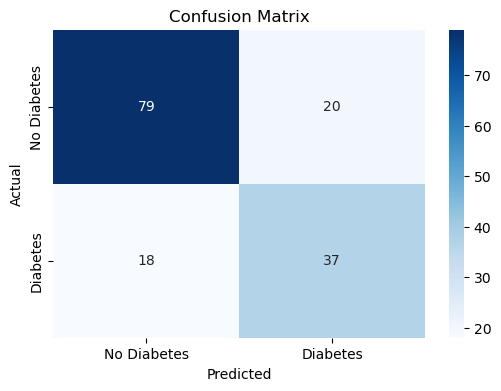

In [19]:
def plot_confusion_matrix(y_true, y_pred, labels=['Negative', 'Positive']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, labels=['No Diabetes', 'Diabetes'])

In [20]:
# ROC AUC // probabilities
y_prob = model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.835186567164179

### ROC AUC Score Interpretation
A ROC AUC score of 0.835186567164179 indicates that the model is effective at distinguishing between the positive and negative classes. Generally, a higher ROC AUC score (closer to 1) is desirable.

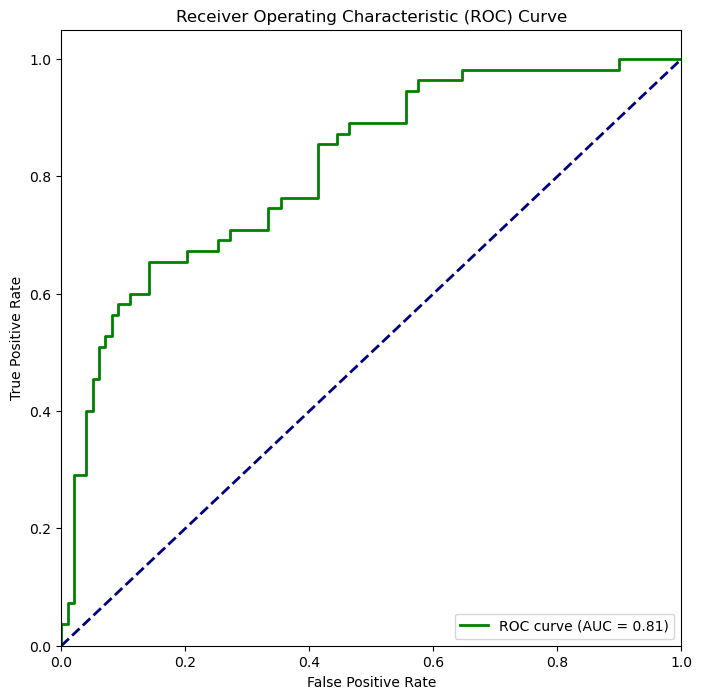

In [21]:
y_prob = model.predict_proba(X_test)

def plot_roc_curve(y_true, y_prob):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_prob)

In [22]:
# Model Validation: 10-Fold Cross Validation

y = scaled_data["Outcome"]
X = scaled_data.drop(["Outcome"], axis=1)
# Fitting our model, using all the data for cross-validation
log_model = LogisticRegression().fit(X, y)
# Providing independent variables, specifying 5-fold cross-validation, calculating multiple performance metrics
cv_results = cross_validate(log_model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [23]:
# Taking the average of the 5 calculated test scores
cv_results['test_accuracy'].mean()

0.7721925133689839

In [24]:
# Taking the average of the 5 calculated precision scores
cv_results['test_precision'].mean()

0.7192472060223519

In [25]:
# Taking the average of the 5 calculated recall scores
cv_results['test_recall'].mean()

0.5747030048916841

In [26]:
# Taking the average of the 5 calculated test F1 scores
cv_results['test_f1'].mean()

0.6371421090986309

In [27]:
# Taking the average of the 5 calculated roc auc scores
cv_results['test_roc_auc'].mean()

0.832801537386443

### KNN Modeling

In [28]:
# Using KNN
# Data Preprocessing
y = data['Outcome']
X = data.drop(['Outcome'], axis=1)

# Apply StandardScaler, returning a numpy array
X_scaled = StandardScaler().fit_transform(X)
# Convert back to a DF
X = pd.DataFrame(X_scaled, columns = X.columns)

In [29]:
# MOdelling 
knn_model = KNeighborsClassifier().fit(X, y)
# We draw a random sample
random_user = X.sample(1, random_state=45)
# We make a prediction
knn_model.predict(random_user)

array([1], dtype=int64)

In [30]:
# Model Evaluation
# For the confusion matrix:
y_pred = knn_model.predict(X)
# For AUC:
y_prob = knn_model.predict_proba(X)[:, 1]

print(classification_report(y, y_pred))
# Checking the roc_auc score
roc_auc_score(y, y_prob)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.79      0.70      0.74       268

    accuracy                           0.83       768
   macro avg       0.82      0.80      0.81       768
weighted avg       0.83      0.83      0.83       768



0.9020149253731343

### Metrics Analysis

Precision:

Precision for class 0 (No Diabetes): 0.85
Out of all instances predicted as class 0, 85% are truly class 0.
Precision for class 1 (Diabetes): 0.79
Out of all instances predicted as class 1, 79% are truly class 1.

Recall (Sensitivity):
Recall for class 0: 0.90
Out of all actual class 0 instances, the model correctly identifies 90%.
Recall for class 1: 0.70
Out of all actual class 1 instances, the model correctly identifies 70%.

F1-Score:
F1-Score for class 0: 0.87
The harmonic mean of precision and recall for class 0.
F1-Score for class 1: 0.74
The harmonic mean of precision and recall for class 1.

Accuracy:
Overall correctness of predictions: 0.83
The model is correct 83% of the time across both classes.
Macro Avg:
The average of precision, recall, and F1-score across classes.
Macro average precision: 0.82, recall: 0.80, F1-score: 0.81
Weighted Avg:
Similar to the macro average, but it considers the number of instances for each class.
Weighted average precision: 0.83, recall: 0.83, F1-score: 0.83
Interpretation:

The model performs well in terms of precision, recall, and F1-score for both classes, indicating a balanced performance.
Class 0 (No Diabetes) has higher precision, recall, and F1-score than class 1 (Diabetes).
The weighted average takes into account the class imbalance, providing an overall performance metric for the model.

The ROC AUC score of 0.902 indicates that your binary classification model has a very good ability to discriminate between the two classes. It suggests that the model is effective at assigning higher predicted probabilities to positive instances compared to negative instances, leading to a strong separation between the positive and negative classes on the ROC curve.